# PROIECT CPPSMS

### GIRLA  Ionut-Alexandru 411-Siva

Importarea bibliotecilor necesare

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import pickle
import ipyplot
import pandas as pd
import statistics
import random
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

Definirea variabilelor globale considerate

In [2]:
DATADIR = './UCMerced_LandUse/Images/'

CATEGORIES = ['agricultural', 'airplane', 'baseballdiamond'
              , 'beach', 'buildings', 'chaparral'
             , 'denseresidential', 'forest', 'freeway'
             , 'golfcourse', 'harbor', 'intersection'
             ,'mediumresidential', 'mobilehomepark', 'overpass'
             ,'parkinglot', 'river', 'runway'
             ,'sparseresidential', 'storagetanks', 'tenniscourt']

COMPONENTS = ['BLUE','GREEN', 'RED']


Importarea datelor

In [3]:
def import_dataset():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category) #CONVERT CATEGORY NAME TO A NUMBER
        #print(f"os.listdir(path) {os.listdir(path)}")
        for img in os.listdir(path):
            try: 
                img_array = cv2.imread(os.path.join(path,img))
                dim = (200, 200)
                img_array = cv2.resize(img_array, dim, interpolation = cv2.INTER_AREA)
                (b, g, r) = cv2.split(img_array)
                r = np.array(r.flatten())
                g = np.array(g.flatten())
                b = np.array(b.flatten())
                image = [b, g ,r]
                image = np.array(image, dtype = np.float32) #img -> array
                image = np.array(image.flatten())
                dataset.append([image, class_num])
            except Exception as e:
                pass
dataset = [] 
import_dataset()
print(np.shape(dataset))


(2100, 2)


E:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Impartirea in Matrice de caracteristici si Vectorul de valori dependente

In [4]:
X = [] #Matrice de caracteristici
y = [] #Vector de valori dependente
for features, label in dataset:
    X.append(features)
    y.append(label)

Calcularea vectorului de medii si al celui de variante pentru fiecare imagine pe fiecare dintre cele 3 componente (BGR)

In [5]:
mean_vector = []
var_vector = []
for index in range(len(X)):
    mean_values = []
    var_values = []
    current_image  = X[index]
    #print(np.shape(current_image))
    for component in range (0, 3):
        suma = 0
        for i in range(0, 200*200):
            suma += current_image[i+ 200*200*component]
        mean = suma/(200*200)
        mean_values.append(mean)
        
        deviations = [(x - mean) ** 2 for x in current_image[200*200*component: 200*200*(component+1)]]
        variance = sum(deviations)/(200*200)
        var_values.append(variance)
    var_vector.append(var_values)
    mean_vector.append(mean_values)

print(np.shape(mean_vector))
print(np.shape(var_vector))

(2100, 3)
(2100, 3)


Salvarea vectorului de medii si al celui de variante in fisiere text

In [6]:
print(mean_vector[0])
print(var_vector[0])

f = open( 'mean_vector.txt', 'w' )
for i in mean_vector:
    #print(i)
    f.write(str(i) + "\n")
f.close()

f = open( 'var_vector.txt', 'w' )
for i in var_vector:
    #print(i)
    f.write(str(i) + "\n")
f.close()

[111.928825, 116.807375, 115.970475]
[328.44650911937447, 371.02002060937076, 407.9642032743669]


Calcularea Histogramei in grupuri de cate 32 de pixeli pentru fiecare imagine

In [7]:
hist_vector = []

for index in range(0,len(X)):
    img  = X[index]
    color = ('b','g','r')
    hist_values = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([img[200*200*i: 200*200*(i+1)]],[0],None,[8],[0,256])        
        list_histr = histr.tolist()
        flat_list = [item for sublist in list_histr for item in sublist]
        #hist_values.append(flat_list)
        hist_values = np.concatenate((hist_values, flat_list))
    hist_vector.append(hist_values) 

print(np.shape(hist_vector))
    

(2100, 24)


In [8]:
print((hist_vector[0]))

[    0.   412.  5080. 29555.  4436.   370.    66.    81.     0.   445.
  3815. 26061.  9016.   510.    70.    83.     0.   403.  4318. 26147.
  8170.   787.    86.    89.]


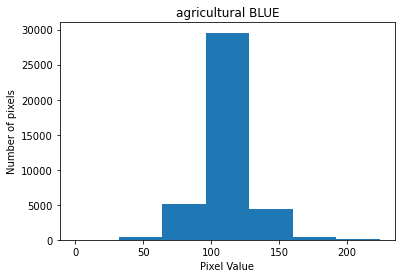

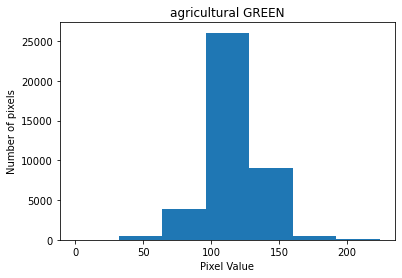

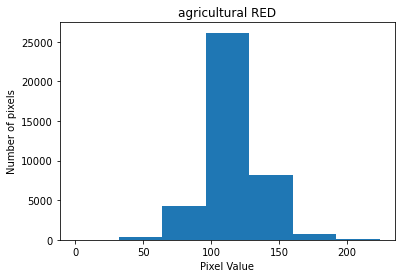

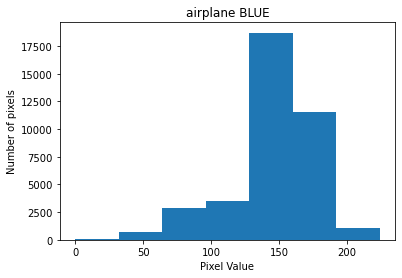

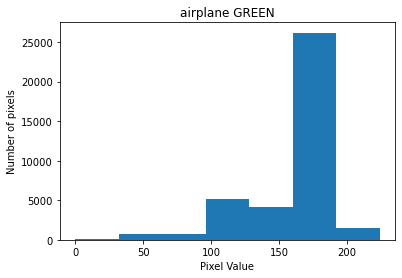

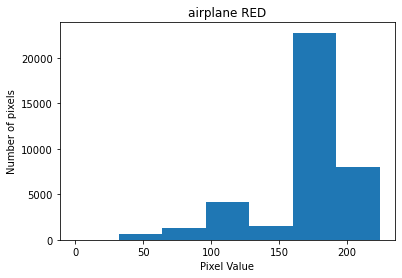

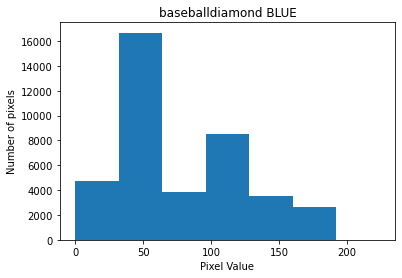

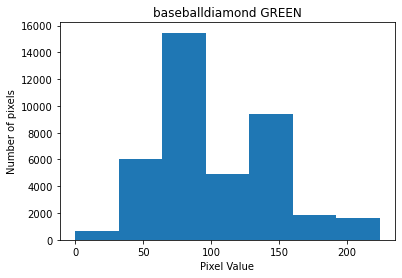

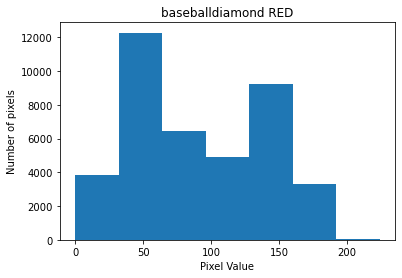

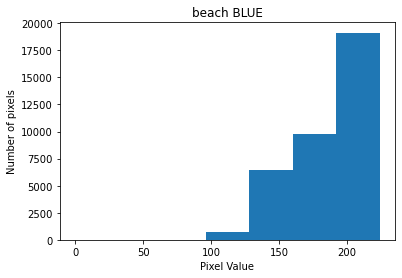

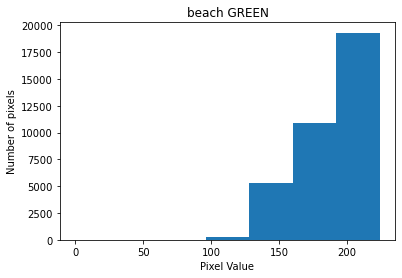

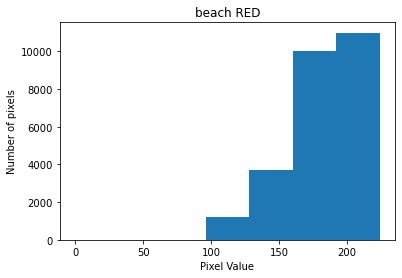

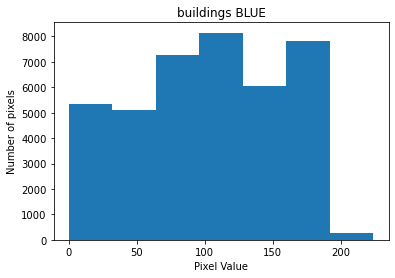

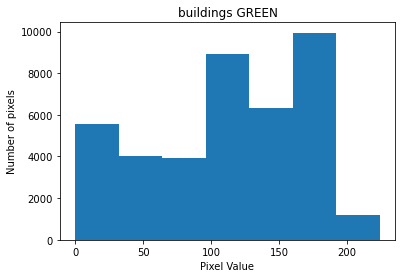

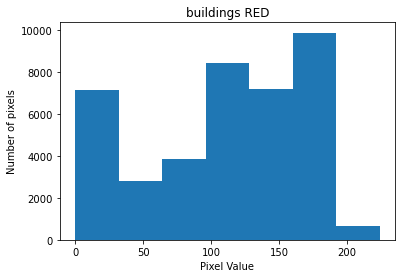

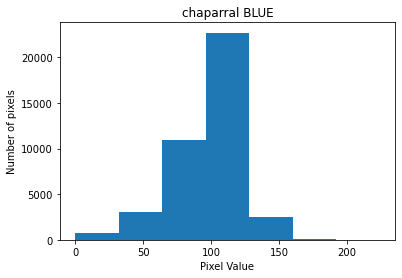

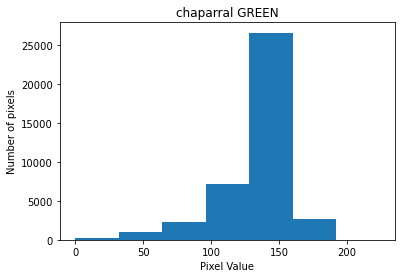

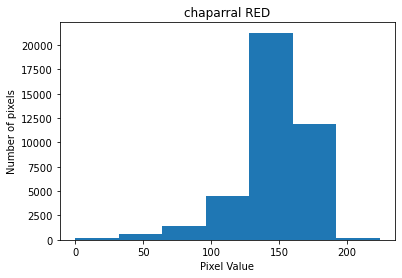

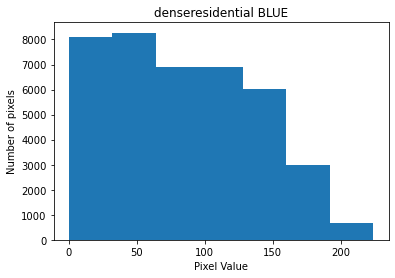

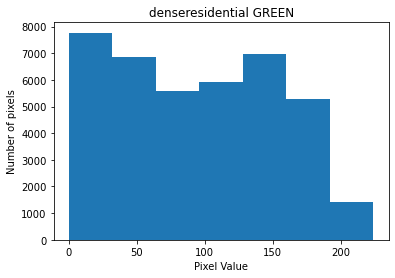

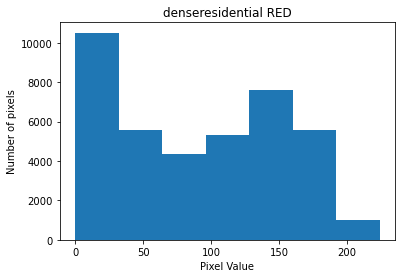

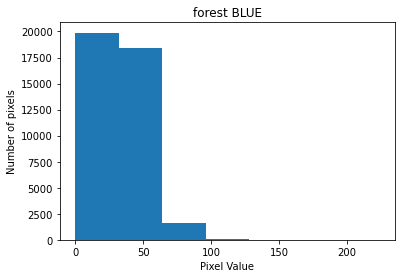

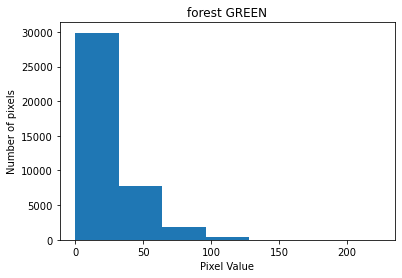

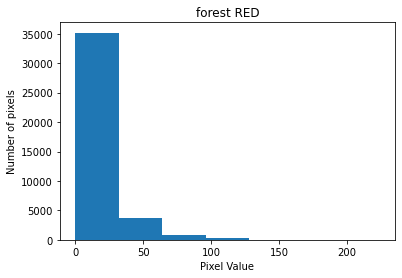

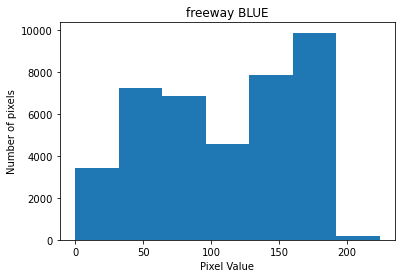

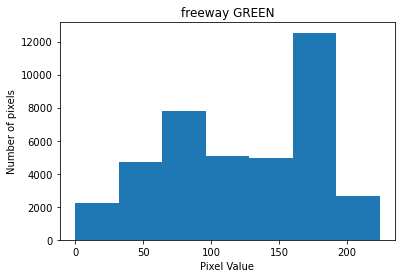

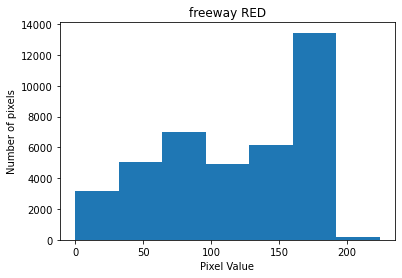

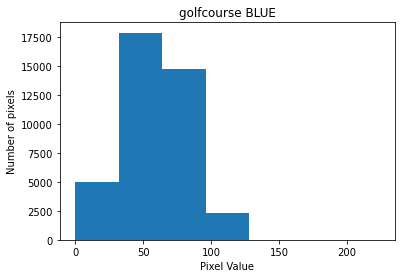

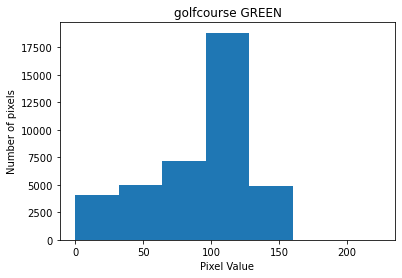

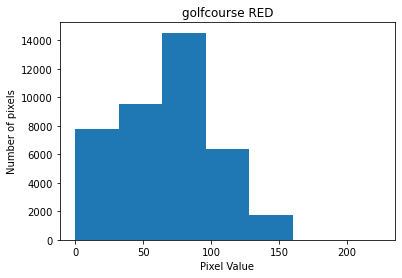

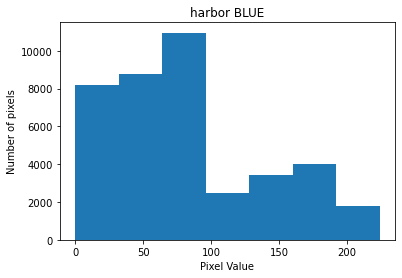

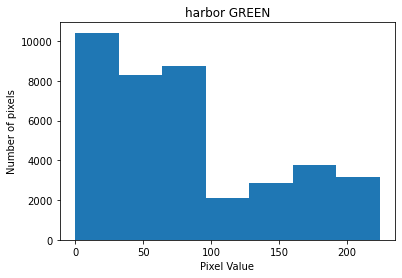

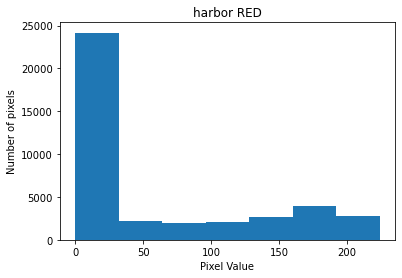

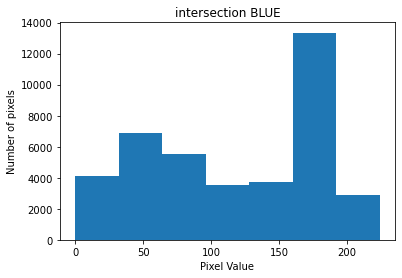

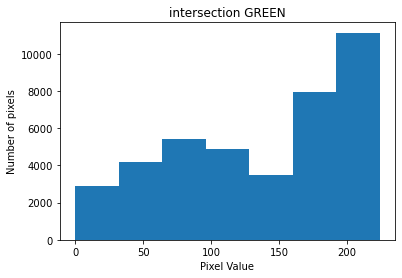

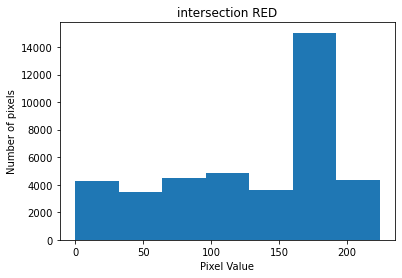

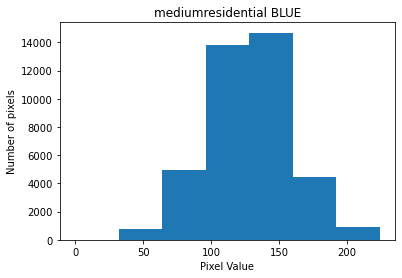

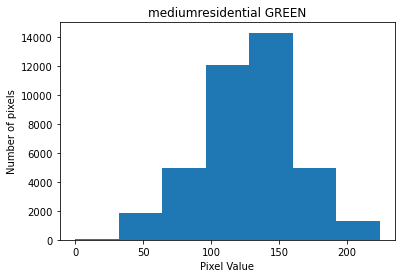

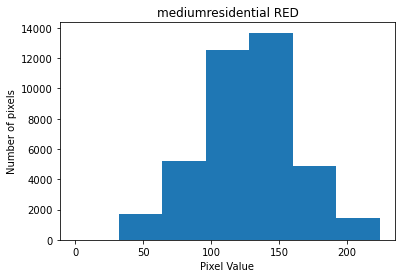

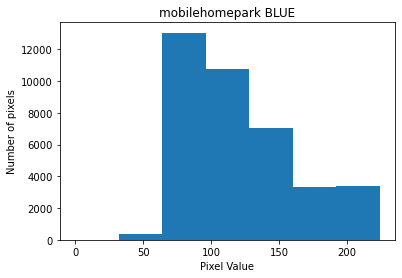

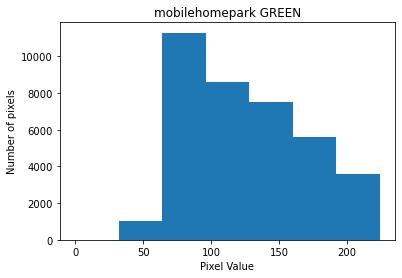

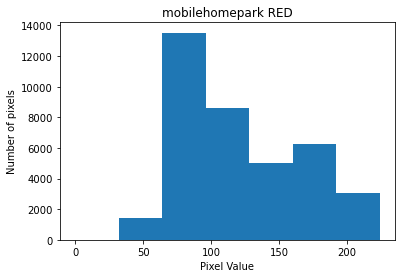

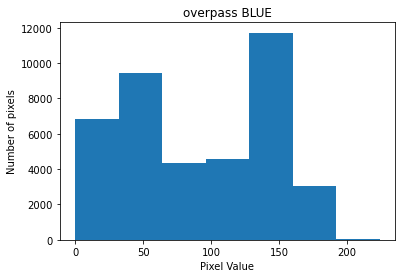

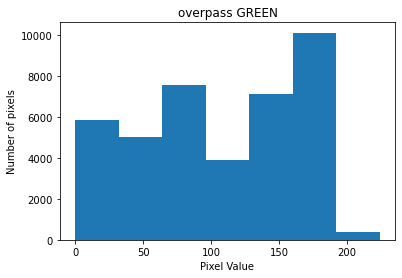

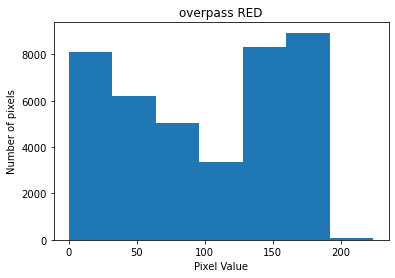

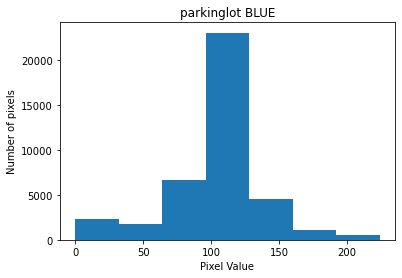

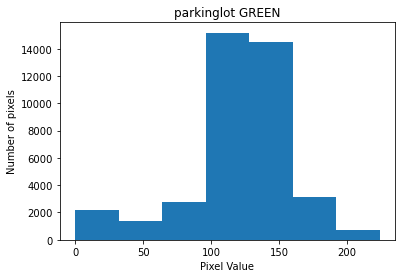

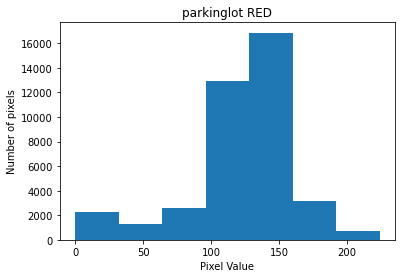

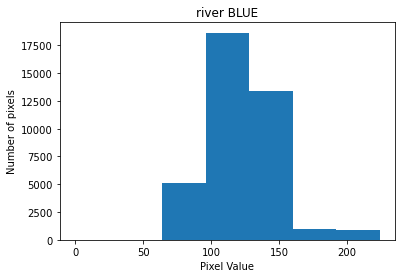

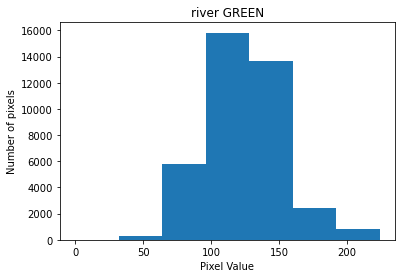

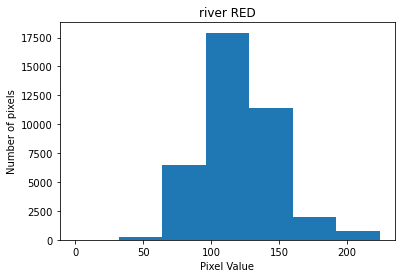

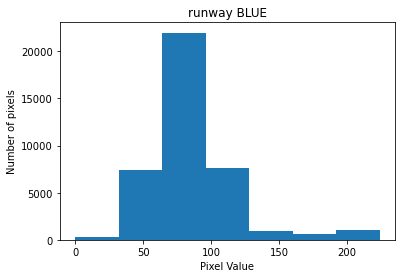

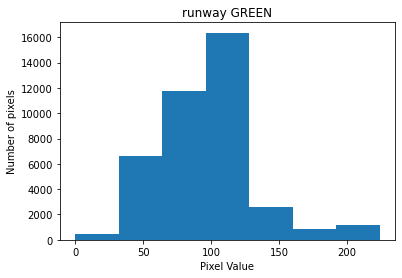

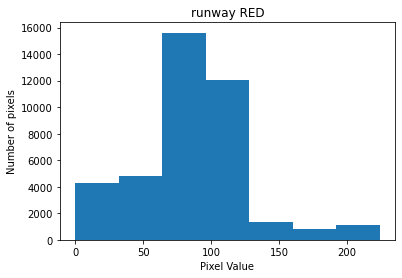

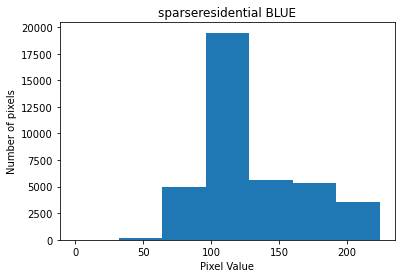

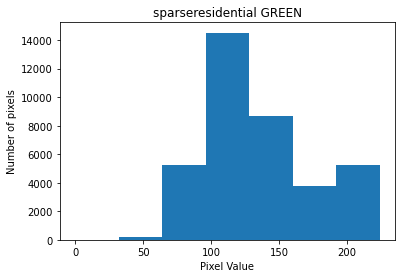

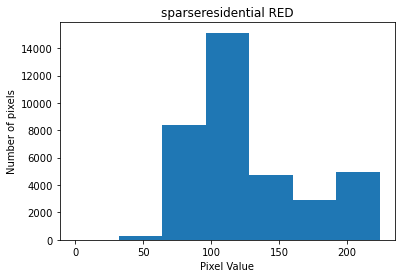

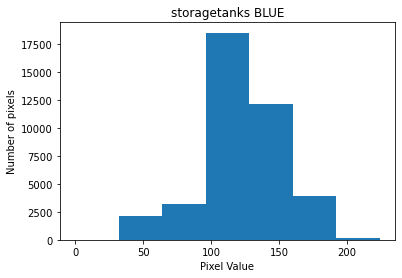

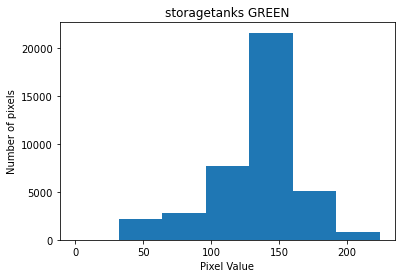

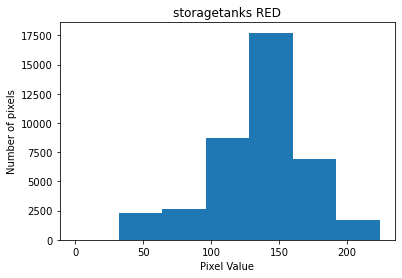

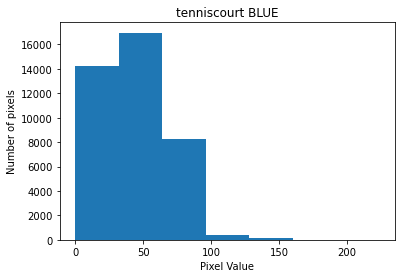

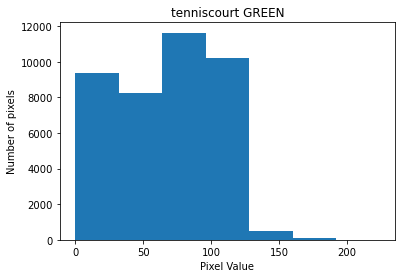

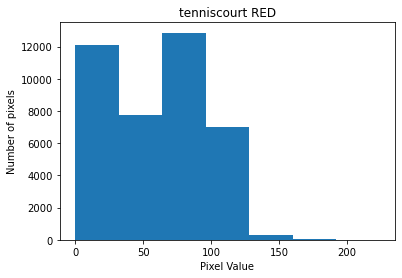

In [9]:
for index in range(0,len(X),100):
    current_image  = X[index]
    for component in range (0, 3):
        bins = range(0, 256,32)
        plt.hist(current_image[200*200*component: 200*200*(component+1)],bins=bins)
        plt.title(CATEGORIES[y[index]] + ' ' + COMPONENTS[component] )
        plt.xlabel('Pixel Value')
        plt.ylabel('Number of pixels')
        plt.show()

Calcularea mediei pe componente pentru fiecare clasa

In [10]:
means_per_classes = []
var_per_classes = []

for i in range(21):
    means_per_classes.append(np.mean(mean_vector[i*100:(i+1)*100], axis = 0))

for i in range(21):
    var_per_classes.append(np.var(var_vector[i*100:(i+1)*100], axis = 0))
    

Afisarea mediei pe componente pentru fiecare clasa urmata de afisarea unei singure valori pentru fiecare clasa reprezentata de media valorilor afisate anterior

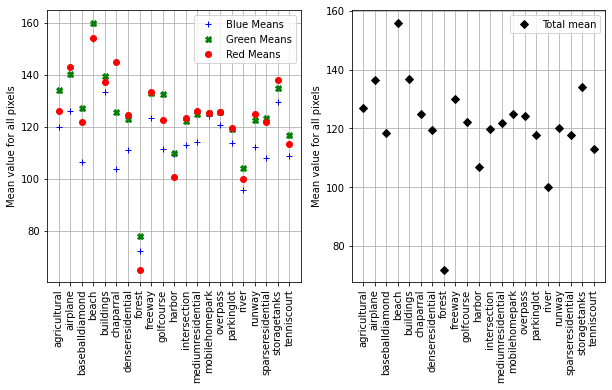

In [11]:
x = range(21)
y_red = []
y_blue = []
y_green = []

for blue,green,red in means_per_classes:
    y_blue.append(blue)
    y_green.append(green)
    y_red.append(red)
    
blue_means = np.array([x,y_blue])
green_means = np.array([x,y_green])
red_means = np.array([x,y_red])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.xticks(x,CATEGORIES,rotation=90)
plt.grid()
plt.plot(blue_means[0,],blue_means[1,],'b+')
plt.plot(green_means[0,],green_means[1,],'gX')
plt.plot(red_means[0,],red_means[1,],'ro')
plt.legend(["Blue Means", "Green Means", "Red Means"] )
plt.ylabel("Mean value for all pixels")

###################################

y_lum = []
for blue,green,red in means_per_classes:
    y_lum.append((blue + green + red )/3)
total_means = np.array([x,y_lum])

plt.subplot(1, 2, 2)
plt.xticks(x,CATEGORIES,rotation=90)
plt.grid()
plt.plot(total_means[0,],total_means[1,],'kD')
plt.legend(["Total mean"] )
plt.ylabel("Mean value for all pixels")

plt.show()


Afisarea Variantei pe componenta pentru fiecare clasa urmata de afisarea mediei acestor valori pentru fiecare clasa.

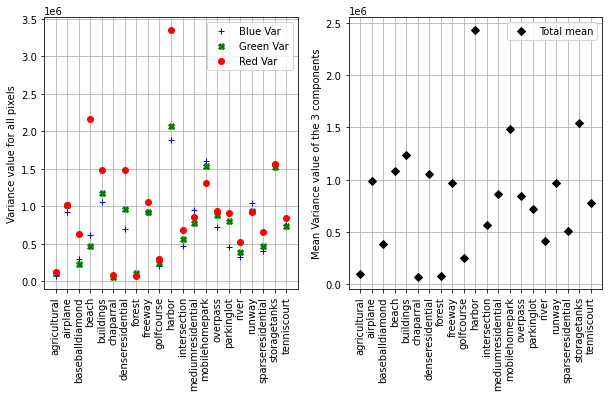

In [12]:
x = range(21)
y_red = []
y_blue = []
y_green = []

for blue,green,red in var_per_classes:
    y_blue.append(blue)
    y_green.append(green)
    y_red.append(red)
    
blue_var = np.array([x,y_blue])
green_var = np.array([x,y_green])
red_var = np.array([x,y_red])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.xticks(x,CATEGORIES,rotation=90)
plt.grid()
plt.plot(blue_var[0,],blue_var[1,],'b+')
plt.plot(green_var[0,],green_var[1,],'gX')
plt.plot(red_var[0,],red_var[1,],'ro')
plt.legend(["Blue Var", "Green Var", "Red Var"] )
plt.ylabel("Variance value for all pixels")


y_lum = []
for blue,green,red in var_per_classes:
    y_lum.append((blue + green + red )/3)
total_var = np.array([x,y_lum])

plt.subplot(1, 2, 2)
plt.xticks(x,CATEGORIES,rotation=90)
plt.grid()
plt.plot(total_var[0,],total_var[1,],'kD')
plt.legend(["Total mean"] )
plt.ylabel("Mean Variance value of the 3 components")

plt.show()

Impartirea setului de date in date de antrenare si date de testare

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

Grid search pentru a obtine cea mai buna combinatie de metoda de scalare a datelor, numar de componente principale pastrate si numar de vecini considerati "K" astfel incat scorul de acuratete sa fie maxim.

4
(4, 3)


E:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Combinatia: No scaling, 10, 5 este gata cu acuratetea: 29.20634920634921
Combinatia: No scaling, 10, 10 este gata cu acuratetea: 29.523809523809526
Combinatia: No scaling, 10, 20 este gata cu acuratetea: 25.396825396825395
Combinatia: No scaling, 10, 50 este gata cu acuratetea: 22.53968253968254
Combinatia: No scaling, 15, 5 este gata cu acuratetea: 29.841269841269842
Combinatia: No scaling, 15, 10 este gata cu acuratetea: 30.158730158730158
Combinatia: No scaling, 15, 20 este gata cu acuratetea: 25.07936507936508
Combinatia: No scaling, 15, 50 este gata cu acuratetea: 21.58730158730159
Combinatia: No scaling, 20, 5 este gata cu acuratetea: 29.841269841269842
Combinatia: No scaling, 20, 10 este gata cu acuratetea: 30.793650793650794
Combinatia: No scaling, 20, 20 este gata cu acuratetea: 24.126984126984127
Combinatia: No scaling, 20, 50 este gata cu acuratetea: 20.0
Combinatia: No scaling, 50, 5 este gata cu acuratetea: 25.07936507936508
Combinatia: No scaling, 50, 10 este gata cu acur

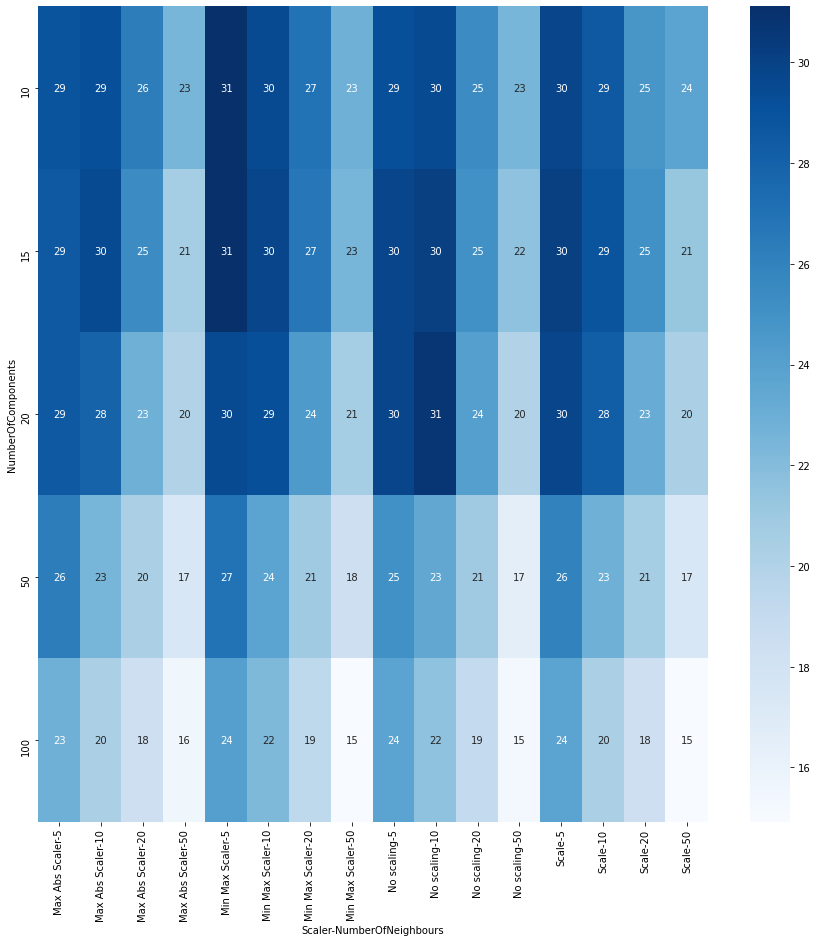

In [14]:
acc_list = []
scaling = [
    ('No scaling', x_train, x_test),
    ('Scale', preprocessing.scale(x_train), preprocessing.scale(x_test)),
    ('Min Max Scaler', MinMaxScaler().fit_transform(x_train), MinMaxScaler().fit_transform(x_test)),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(x_train), MaxAbsScaler().fit_transform(x_test))
]

print(len(scaling))
print(np.shape(scaling))

#pca_values = [5, 10, 15, 20, 25, 35, 50, 100, 200, 400]
pca_values = [10, 15, 20, 50, 100]
knn_nei = [5,10,20,50]
for name, train, test in scaling:
    for number_of_components in pca_values:
        for number_of_neighbours in knn_nei:
            train_local = copy.copy(train)
            test_local = copy.copy(test)
            pca = PCA(n_components = number_of_components)
            x_train_curent = pca.fit_transform(train_local)
            x_test_curent = pca.transform(test_local)    
            clf = KNeighborsClassifier(n_neighbors = number_of_neighbours, metric = 'minkowski', p = 2)
            clf.fit(x_train_curent, y_train)
            y_predicted = clf.predict(x_test_curent)
            acc_list.append([name, number_of_components,number_of_neighbours, accuracy_score(y_predicted, y_test)*100])
            print(f"Combinatia: {name}, {number_of_components}, {number_of_neighbours} este gata cu acuratetea: {accuracy_score(y_predicted, y_test)*100}")
acc_df = pd.DataFrame(acc_list)
acc_df.columns = ['Scaler', 'NumberOfComponents', 'NumberOfNeighbours', 'Accuracy']

print(acc_df[acc_df.Accuracy == acc_df.Accuracy.max()])

heatmap = pd.pivot_table(acc_df, values='Accuracy', 
                     index=['NumberOfComponents'], 
                     columns=['Scaler','NumberOfNeighbours'])

plt.figure(figsize=(15,15))
sn.heatmap(heatmap, annot=True, cmap="Blues")
plt.show()

Verificare matrice de confuzie pentru cea mai buna combinatie:

In [15]:
x_train_local = MaxAbsScaler().fit_transform(x_train)
x_test_local  = MaxAbsScaler().fit_transform(x_test)

pca = PCA(n_components = 15)
x_train_curent = pca.fit_transform(x_train_local)
x_test_curent = pca.transform(x_test_local)    

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(x_train_curent, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test_curent)
accuracy_score(y_pred, y_test)*100

28.57142857142857

Afisarea matricei de confuzie pentru cea mai buna combinatie

In [16]:
cm = confusion_matrix(y_true = y_test[:] ,y_pred = y_pred)
print(cm)

[[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  1  1  2  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 2  1  6  2  0  2  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  2  1  2  0  0  0  1  0  0  0  3  1  0  2  0  0  0  1  0]
 [ 3  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  3  1  0  0  2  1  0  0  1  0  1  1  0  1  1  0  0  0  0  0]
 [ 3  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  1  0  2  1  1  3  0  0  0  0  0  2  0  0  1  1  0  0]
 [ 6  1  1  0  0  0  0  0  0  1  0  1  0  0  0  1  1  0  1  0  0]
 [ 0  1  1  0  1  0  0  0  0  1  5  0  0  0  0  0  2  1  0  0  0]
 [ 3  0  0  0  0  0  1  1  0  1  0  2  0  1  2  0  0  0  0  1  1]
 [ 8  0  1  0  0  3  1  1  0  1  0  0  0  0  0  1  2  0  0  1  0]
 [ 7  0  0  0  1  3  0  3  0  1  0  1  0  1  0  1  0  0  0  0  0]
 [ 2  1  2  1  0  0  2  0  2  0  0  0  0  0  1  0  0  0  0  0  0]
 [11  1  0

Incercarea de a obtine rezultate mai bune prin variatia metricii utilizate

Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 5, Metric: euclidean este gata cu acuratetea: 25.396825396825395
Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 5, Metric: manhattan este gata cu acuratetea: 25.07936507936508
Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 5, Metric: chebyshev este gata cu acuratetea: 24.444444444444443
Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 10, Metric: euclidean este gata cu acuratetea: 26.666666666666668
Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 10, Metric: manhattan este gata cu acuratetea: 25.71428571428571
Combinatia: Scaler: No scaling, Number of PCA Components: 5, Number of Neighbours: 10, Metric: chebyshev este gata cu acuratetea: 25.71428571428571
Combinatia: Scaler: No scaling, Number of PCA Components: 10, Number of Neighbours: 5, Metric: euclidean este ga

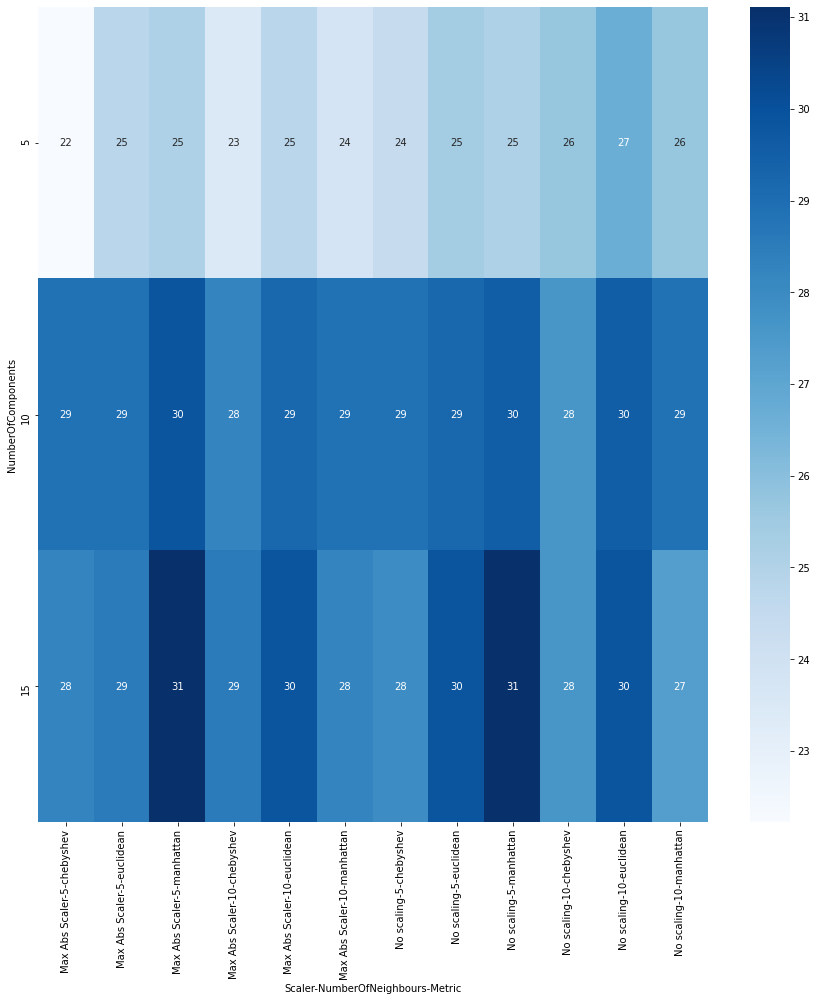

In [17]:
acc_list = []
scaling = [
    ('No scaling', x_train, x_test),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(x_train), MaxAbsScaler().fit_transform(x_test))
]

pca_values = [5,10, 15]
knn_nei = [5,10]
knn_metric = ['euclidean','manhattan','chebyshev', ]
for name, train, test in scaling:
    for number_of_components in pca_values:
        for number_of_neighbours in knn_nei:
            for knn_met in knn_metric:
                train_local = copy.copy(train)
                test_local = copy.copy(test)
                pca = PCA(n_components = number_of_components)
                x_train_curent = pca.fit_transform(train_local)
                x_test_curent = pca.transform(test_local)    
                clf = KNeighborsClassifier(n_neighbors = number_of_neighbours, metric = knn_met)
                clf.fit(x_train_curent, y_train)
                y_predicted = clf.predict(x_test_curent)
                acc_list.append([name, number_of_components,number_of_neighbours, knn_met,accuracy_score(y_predicted, y_test)*100])
                print(f"Combinatia: Scaler: {name}, Number of PCA Components: {number_of_components}, Number of Neighbours: {number_of_neighbours}, Metric: {knn_met} este gata cu acuratetea: {accuracy_score(y_predicted, y_test)*100}")
acc_df = pd.DataFrame(acc_list)
acc_df.columns = ['Scaler', 'NumberOfComponents', 'NumberOfNeighbours','Metric', 'Accuracy']

print(acc_df[acc_df.Accuracy == acc_df.Accuracy.max()])

heatmap = pd.pivot_table(acc_df, values='Accuracy', 
                     index=['NumberOfComponents'], 
                     columns=['Scaler','NumberOfNeighbours','Metric'])

plt.figure(figsize=(15,15))
sn.heatmap(heatmap, annot=True, cmap="Blues")
plt.show()

# Incercare clasificare dupa medie si varianta pe componenta

In [18]:

new_dataset = np.concatenate((mean_vector, var_vector),axis = 1)
new_dataset = np.concatenate((new_dataset,hist_vector),axis = 1)
print(np.shape(new_dataset))

(2100, 30)


In [19]:
print(new_dataset[0])

[  111.928825     116.807375     115.970475     328.44650912
   371.02002061   407.96420327     0.           412.
  5080.         29555.          4436.           370.
    66.            81.             0.           445.
  3815.         26061.          9016.           510.
    70.            83.             0.           403.
  4318.         26147.          8170.           787.
    86.            89.        ]


In [20]:
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_dataset, y, test_size = 0.15)

    Scaler  NumberOfComponents  NumberOfNeighbours     Metric   Accuracy
217  Scale                  30                   1  manhattan  69.206349


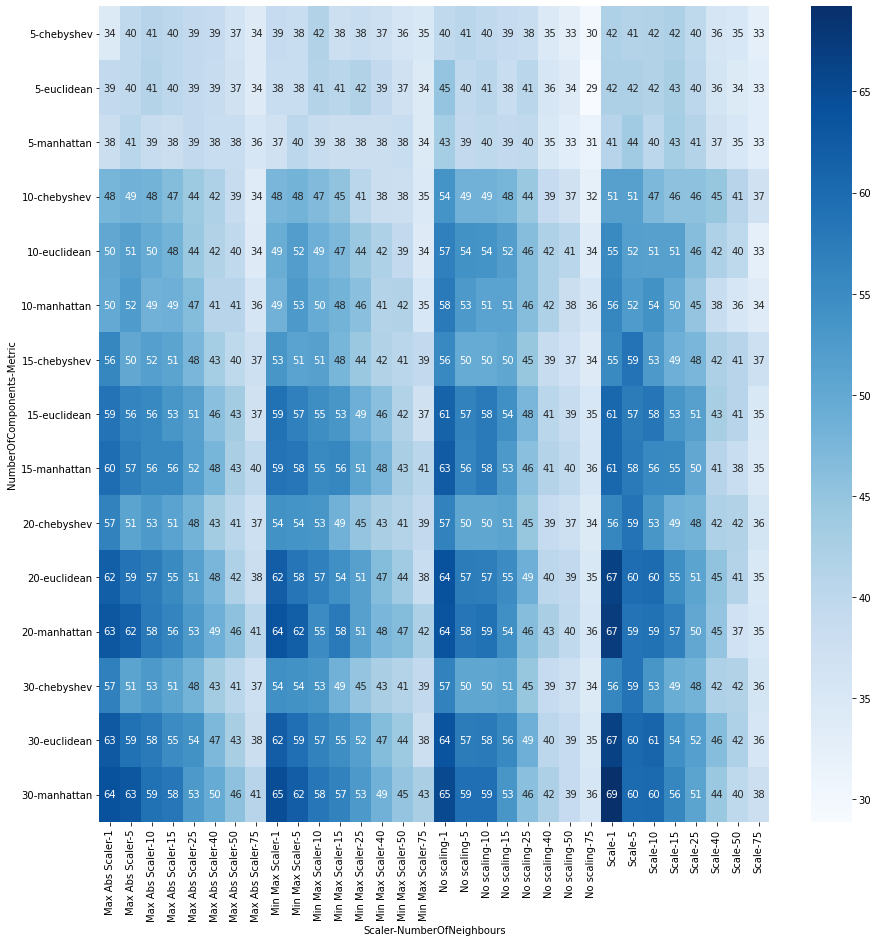

In [21]:
acc_list = []
scaling = [
    ('No scaling', new_x_train, new_x_test),
    ('Scale', preprocessing.scale(new_x_train), preprocessing.scale(new_x_test)),
    ('Min Max Scaler', MinMaxScaler().fit_transform(new_x_train), MinMaxScaler().fit_transform(new_x_test)),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(new_x_train), MaxAbsScaler().fit_transform(new_x_test))
]

pca_values = [5,10,15,20,30]
knn_nei = [1,5,10,15,25,40,50,75]
knn_metric = ['euclidean','manhattan','chebyshev']
for name, train, test in scaling:
    for number_of_components in pca_values:
        for number_of_neighbours in knn_nei:
            for knn_met in knn_metric:
                train_local = copy.copy(train)
                test_local = copy.copy(test)
                pca = PCA(n_components = number_of_components)
                x_train_curent = pca.fit_transform(train_local)
                x_test_curent = pca.transform(test_local)    
                clf = KNeighborsClassifier(n_neighbors = number_of_neighbours, metric = knn_met)
                clf.fit(x_train_curent, new_y_train)
                y_predicted = clf.predict(x_test_curent)
                acc_list.append([name, number_of_components,number_of_neighbours, knn_met,accuracy_score(y_predicted, new_y_test)*100])
                #print(f"Combinatia: Scaler: {name}, Number of PCA Components: {number_of_components}, Number of Neighbours: {number_of_neighbours}, Metric: {knn_met} este gata cu acuratetea: {accuracy_score(y_predicted, new_y_test)*100}")
acc_df = pd.DataFrame(acc_list)
acc_df.columns = ['Scaler', 'NumberOfComponents', 'NumberOfNeighbours','Metric', 'Accuracy']

print(acc_df[acc_df.Accuracy == acc_df.Accuracy.max()])

heatmap = pd.pivot_table(acc_df, values='Accuracy', 
                     index=['NumberOfComponents','Metric'], 
                     columns=['Scaler','NumberOfNeighbours'])

plt.figure(figsize=(15,15))
sn.heatmap(heatmap, annot=True, cmap="Blues")
plt.show()

In [25]:
x_train_local = preprocessing.scale(new_x_train)
x_test_local  = preprocessing.scale(new_x_test)

pca = PCA(n_components = 30)
x_train_curent = pca.fit_transform(x_train_local)
x_test_curent = pca.transform(x_test_local)    

classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'manhattan')
classifier.fit(x_train_curent, new_y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test_curent)
accuracy_score(y_pred, new_y_test)*100

69.2063492063492

In [26]:
cm = confusion_matrix(y_true = new_y_test[:] ,y_pred = y_pred)
print(cm)

[[14  0  1  0  0  1  0  2  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 12  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  0]
 [ 0  0  0  1  7  0  2  0  1  0  0  1  0  3  2  0  1  0  0  0  0]
 [ 0  1  0  0  0 18  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  7  0  0  0  0  0  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 13  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0 13  0  1  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  2  0  0  6  1  0  1  1  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 12  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  1  0  0  4  0  0  7  1  0  0  0  0  0]
 [ 0  3  1

In [27]:
print(classification_report(new_y_test, y_pred, target_names=CATEGORIES, digits=4))

                   precision    recall  f1-score   support

     agricultural     1.0000    0.7000    0.8235        20
         airplane     0.6923    0.7500    0.7200        12
  baseballdiamond     0.6667    0.8571    0.7500        14
            beach     0.8889    0.8421    0.8649        19
        buildings     0.5385    0.3889    0.4516        18
        chaparral     0.8571    0.9000    0.8780        20
 denseresidential     0.6364    0.7000    0.6667        10
           forest     0.7857    0.8462    0.8148        13
          freeway     0.6500    0.8125    0.7222        16
       golfcourse     0.6842    0.6842    0.6842        19
           harbor     1.0000    0.9375    0.9677        16
     intersection     0.3750    0.4000    0.3871        15
mediumresidential     0.6000    0.8571    0.7059        14
   mobilehomepark     0.7059    0.8571    0.7742        14
         overpass     0.3889    0.5000    0.4375        14
       parkinglot     0.6842    0.6500    0.6667       